# [`XLA.jl`](https://github.com/JuliaTPU/XLA.jl): Shakespeare RNN

In this notebook, we will showcase using `XLA.jl` with LSTMs to learn the structure of Shakespearean english.  It is assumed that you have already viewed the previous two introductory notebooks that cover the [basics of TPU compilation](1_ResNet_Intro.ipynb) and [writing a training loop](2_ResNet_Training.ipynb).  In this notebook, we will engage in distributed training, using all eight cores of a single TPU device to train in parallel.  The basic task will be to take a sequence of Shakespeare text (garnered from [this text file](https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt)) and learn to predict the next character, using some kind of recurrent neural architecture.  Once that model is trained up to some level of accuracy, we will read off output from randomized activations to generate new Shakespearean sonnets.

In order to deal with recurrent architectures on the TPU, we are going to need to engage in a few unorthodox behaviors.  First and foremost, our automatic differentiation will not be able to deal with the loops we would normally use to implement our LSTM chewing through the time dimension of the input batch of data, because it currently uses mutable data structures to deal with this (building a stack to track values through the loop iterations) and this is incompatible with our programming model for the TPU.  To address this, we explicitly unroll that loop using the [Unrolled.jl](https://github.com/cstjean/Unrolled.jl) package, making use of the `@unroll` macro.

In [1]:
## Load package versions that are known to work with TPUs, check that Julia version is a known compatible one
if Base.GIT_VERSION_INFO.commit != "0424938442a907a35089254d2bd14b731c2008ec"
    @warn("Only the very latest Julia version on the `kf/tpu3` branch is supported!")
end

import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


## Dataset setup

We download the dataset, parse it, construct our alphabet (the unique set of all characters contained within the input) and map the dataset through this alphabet to encode each character as an integer offset within the `alphabet` mapping:

In [2]:
using TensorFlow, XLA, Flux, Unrolled, Zygote, Printf, Statistics
include("tpu_optimizers.jl")

# First, let's download our dataset;
if !isfile("shakespeare_input.txt")
    download("https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt", "shakespeare_input.txt")
end

# Read text in as a giant string, convert to array of characters
text = collect(String(read("shakespeare_input.txt")))

# Generate alphabet, which we will use as an embedding (along with special "stop" character '_')
alphabet = sort([unique(text)..., '_'])
stop = UInt32(Flux.onehotidx('_', alphabet))

# Embed text through alphabet as UInt32 onehot indices
text = UInt32.(map(ch -> Flux.onehotidx(ch, alphabet), text))

println(" => Loaded $(length(text))-character dataset and encoded into $(length(alphabet))-symbol embedding")

┌ Info: Recompiling stale cache file /home/sabae/.julia/compiled/v1.1/XLA/bZBiw.ji for XLA [1ae4bca4-de81-11e8-0eca-6d3e4e7c4181]
└ @ Base loading.jl:1184
┌ Warning: Package XLA does not have Random in its dependencies:
│ - If you have XLA checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with XLA
└ Loading Random into XLA from project dependency, future warnings for XLA are suppressed.


 => Loaded 4573338-character dataset and encoded into 68-symbol embedding


We chop our dataset up into sequences of length 50 at a time (this is limited essentially only by the precision of the numerics used to calculate the backward pass; if this chain is too long, we run into precision issues as the backward pass attempts to link the contribution of a data input more than 50 time steps in the past from the last sample within a sequence).  For computational efficiency purposes, we will deal with 64 sequences at a time.  We reshape our dataset into a `(sequence_length, batch_size, :)` tensor (padding where appropriate), then create a copy shifted by one character, so that the first dataset is the input, and the second dataset predicts the next character of each input character.

In [3]:
# We will process 64 sequences of length 50 at a time.  Reshape `text` into
# tensors of shape (seq_len, batch_size, batch_idx).  To reshape cleanly, we
# will pad our text with our `stop` character until it is easily reshapable:
batch_size = 64
seq_len = 50
num_batches = ceil(Int, (length(text) - 1)/(seq_len*batch_size))
padded_length = seq_len*batch_size*num_batches + 1
text = vcat(text, repeat([stop], padded_length - length(text)))

# Build Xs and Ys from this text, where each element of `Xs` has its next element
# predicted by the corresponding element of `Ys`.
Xs = reshape(text[1:end-1], (seq_len, batch_size, num_batches))
Ys = reshape(text[2:end-0], (seq_len, batch_size, num_batches))

println(" => Segmented into $(num_batches) batches of size $(batch_size) with $(seq_len)-element sequences")

 => Segmented into 1430 batches of size 64 with 50-element sequences


## Model helpers

One of the fundamental differences of a recurrent neural architecture from the feedforward networks in the previous notebooks is that there will be state encoded within our model.  Here we write some helper functions to get the encoded state values out of a Flux model, as well as functions that set the state for a model (returning a new model, as all objects on a TPU are immutable).

Note that we provide a few unnecessary convenience functions here to deal with `Chain` objects, not just `ImmutableChain` objects, as `Chain` objects are what are used on the CPU, and we like to be able to do the same things on CPU as we do on TPU, for debugging and inspection purposes.

There is also some subtlety around the introduction of "batching" into RNNs; because an RNN must track internal state across time for each independent sample within a batch, the internal state vectors must be able to resize to match whatever batch size is being used.  This is obviously a problem on TPUs, and so what we do is explicitly create an `initialize_state()` method that can be used to perform a "dry run" of the model with an example input, size the internal state tensors appropriately, then return a version of the model with zeroed-out states with the right sizes embedded within it.

In [4]:
# Extract the LSTM state vectors from a model
get_model_state(m::Flux.LSTMCell) = Flux.hidden(m)
get_model_state(m::Flux.Recur) = get_model_state(m.cell)
function get_model_state(model)
    return tuple(
        get_model_state(model.layers[1]),
        get_model_state(model.layers[2]),
    )
end

# Update LSTM state vectors within a model
set_model_state(m::Flux.LSTMCell, state) = Flux.LSTMCell(m.Wi, m.Wh, m.b, state...)
set_model_state(m::Flux.Recur, state) = Flux.Recur(set_model_state(m.cell, state))
function set_model_state(model::ImmutableChain, state)
    return ImmutableChain(
        set_model_state(model.layers[1], state[1]),
        set_model_state(model.layers[2], state[2]),
        model.layers[3],
    )
end

# `Chain` object version, identical except for the `Chain()` constructor name.
function set_model_state(model::Chain, state)
    return Chain(
        set_model_state(model.layers[1], state[1]),
        set_model_state(model.layers[2], state[2]),
        model.layers[3],
    )
end

# Helper function to 
function initialize_state(model, x)
    # Create zero-vectors of the same length (this disregards batch dimension)
    zerovec(h) = Zygote.map(sub_h -> zero(sub_h[:,1]), h)

    # Next, run the new x through the cells to broadcast up the dimensions of h1/h2
    h1, h2 = zerovec.(get_model_state(model))
    h1, x = model.layers[1].cell(h1, x)
    h2, x = model.layers[2].cell(h2, x)

    # Once we have h1/h2 values of the right shape, create zero matrices of that shape
    zeromat(h) = Zygote.map(sub_h -> zero(sub_h), h)
    return set_model_state(model, zeromat.((h1, h2)))
end

initialize_state (generic function with 1 method)

## Model definition

Our model is very simple: Two LSTMs stacked on eachother, and a `Dense` output to squeeze down from internal state size (256) to alphabet size (68).

In [6]:
# Create our model; two stacked LSTMs with 128-element large internal state vectors
model = Chain(
    LSTM(length(alphabet), 256),
    LSTM(256, 256),
    Dense(256, length(alphabet)),
)

# Initialize model with the proper size, then create tpu_model by mapping CPU version over to TPU constructs
model = initialize_state(model, zeros(Float32, length(alphabet), batch_size))
tpu_model = map_to_tpu(model)

println(" => Created model with $(sum([prod(size(p)) for p in params(model)])) trainable parameters")

 => Created model with 875588 trainable parameters


As mentioned before, we cannot let Flux handle RNN state internally; it tries to mutate objects in a way that is fine in normal Julia code, but will not run on TPUs.  To work around this, we define our own function `single_model_timestep()` that allows us to manually define the forward pass of our model.  As usual, we let `Zygote` calculate our backward pass automatically, however because the TPU cannot deal with mutation, we must unroll the `for` loop that processes across time within the sequences we pass in from the outside.

In [7]:
# Push `x` through, updating our state.  Note that normally, with `Flux`, we would
# just call `model(x)`, but because we don't want `Flux` to keep track of the
# internal layer state, we instead manually call the layer methods, passing the
# state vectors in explicitly.
function single_model_timestep(model, state, x)
    # Unpack state for our LSTM layers
    h1, h2 = state
    
    # First, the two LSTM layers
    h1, x = model.layers[1](h1, x)
    h2, x = model.layers[2](h2, x)
    
    # Next, the Dense layer
    y_hat = model.layers[3](x)

    # Return y_hat and our state
    return y_hat, (h1, h2)
end


# Helper function to convert a batch of text at a particular time point into first a OneHotMatrix,
# and then densifying that OneHotMatrix into a typical XRTArray{Float32} which we can apply
# logitcrossentropy loss upon.
function densify(::Val{alphabet_size}, x::XRTArray, t) where {alphabet_size}
    return convert(XRTArray{Float32}, Flux.OneHotMatrix(alphabet_size, x[XRTArray(t), :]))
end
function densify(::Val{alphabet_size}, x, t) where {alphabet_size}
    return Flux.OneHotMatrix(alphabet_size, x[t, :])
end

# This function runs the full model on a batch of `x` and `y` data, returning the resultant loss
# to be minimized.  Note that we must unroll the internal for loop so that our automatic
# differentiation package Zygote doesn't try to dynamically create stacks to track the changing
# variable values through iterations across time.
@unroll function full_model(unused::Val{alphabet_size}, model, x_batch::XRTArray, y_batch::XRTArray) where {alphabet_size}
    # Get current LSTM state
    state = get_model_state(model)
    
    # Accumulate loss into here
    loss = XRTArray(0f0)

    # Iterate over time
    @unroll for time_idx = 1:size(x_batch, 1)
        # Create dense representations of the one-hot encoded text at this point in time, across an entire batch
        x = densify(Val(alphabet_size), x_batch, time_idx)
        
        # Push x through our model to get y_hat (and new recurrent state values)
        y_hat, state = single_model_timestep(model, state, x)
        
        # Accumulate loss
        loss += crossentropy(softmax(y_hat), densify(Val(alphabet_size), y_batch, time_idx))
    end

    # Set model state to save it for next time.
    model = set_model_state(model, state)

    # Return loss and updated model
    return loss, model
end

full_model_unrolled_expansion_ (generic function with 1 method)

## Training loop

Finally, the training loop.  This should look more or less familiar as compared to the previous tutorial, with one big difference; we are doing distributed training, which means that `N` copies of this training loop will be running in parallel on the TPU.  XLA gives us the "Cross-replica sum" abstraction that makes it very easy to average gradient updates over large numbers of nodes within a TPU pod.  We therefore run the forward pass of a minibatch of data on each TPU node in parallel, sync up with a cross-replica sum, perform the backward pass in parallel on each device, then continue forward with the forward pass on the next minibatch of data.

Because minibatches are relatively lightweight in this model, we do not report our training loss every minibatch, instead we store it up within `loss_buffer` and report it once per epoch.  This reduces the communication overhead significantly, and allows us to very quickly iterate toward a convergent model.

In [11]:
function train_model(::Val{alphabet_size}, ::Val{num_epochs}, model, Xs, Ys, η) where {alphabet_size, num_epochs}
    # Create optimizer, in this case ADAM, as gradient scaling is very important for RNNs.
    opt = TPU_ADAM(model, η, (XRTArray(0.9f0), XRTArray(0.999f0)))
    
    # We will report loss once every epoch, store it here in the meantime, one loss value
    # per minibatch, spat out over the wire at the end of every epoch.
    loss_buffer = zero(XRTArray{Float32, (size(Xs, 3),), 1})

    # Iterate over epochs
    epoch_idx = XRTArray(1)
    while epoch_idx <= XRTArray(num_epochs)
        # We need to randomly shuffle our dataset every epoch, both for good convergence
        # properties, and also so that different TPUs are processing different batches
        # in parallel.  To do so, we just randomize the order in which we visit batches
        # in our dataset (our dataset is small enough that it fits on TPU memory no
        # problem).  We do not shuffle the contents of batches, only the order in which
        # we visit the predetermined minibatches.
        batch_permutation = XLA.shuffle(XRTArray(1:size(Xs, 3)))
        
        # Iterate over batches within an epoch
        batch_idx = XRTArray(1)
        while batch_idx <= XRTArray(size(Xs, 3))
            # Calculate forward pass of model, and compile backward pass stored in `back()`.
            # Use `let` block to work around Julia inference limitations.  The forward pass
            # returns a new model, because it will have updated the internal state vectors.
            (loss, model), back = let model=model,
                                      x_batch=Xs[:, :, batch_permutation[batch_idx]],
                                      y_batch=Ys[:, :, batch_permutation[batch_idx]]
                Zygote._forward(
                    Zygote.Context{Nothing}(nothing),
                    model -> full_model(Val(alphabet_size), model, x_batch, y_batch),
                    model,
                )
            end
            
            # Invoke `back()` with sensitivity `1f0` on the `loss`, and `nothing` on the
            # `model` output of `full_model()`.
            Δ_model = Zygote.tailmemaybe(back((1f0, nothing)))[1]

            # Cross-replica sum our model updates to average across all tpus
            Δ_model = XLA.unflatten_tuple(Δ_model,
               XLA.HloCrossReplicaSum{typeof(+)}((), 0, "")(
                   +,
                   XLA.flatten_tuple(Δ_model)...
               )
            )

            # Update parameters via our optimizer
            opt, model = update!(opt, model, Δ_model)

            # Store loss over an epoch into `loss_buffer`.
            loss_buffer = Base.setindex(loss_buffer, loss, batch_idx)

            # Increment batch_idx
            batch_idx += XRTArray(1)
        end
        
        # Once per epoch, output our training loss for the entire epoch
        XLA.HloOutfeed()((loss_buffer,), XLA.HloAfterAll()())
        
        # Increment epoch_idx
        epoch_idx += XRTArray(1)
    end
    
    # Return the trained model (note that this gets returned from each of our TPUs, but we
    # only pay attention to the model returned from the first node, since they are all
    # identical thanks to the cross-replica sum above in the training loop)
    return model
end

train_model (generic function with 1 method)

# Training

As usual, we connect to a TPU on a certain IP, compile our training loop, and run it.  Two differences from previous notebooks here:

* We pass in the `devices=` keyword argument to `@tpu_compile` with a list of all TPU devices connected to this session.  This enables compilation for the distributed training that we are using.

* We use `XLA.run_on_devices()` to do some behind-the-scenes magic that copies our model and datasets onto each device we declared our compilation to run on with the `@tpu_compile` macro.  It returns a Julia `Task` representing the asynchronous program running on the TPU, and attempting to `fetch()` that task will return the return value we defined in our `train_model()` method above, but with the significant difference that it will return eight copies of our model; one for each TPU device.

In [12]:
tpu_ip = "10.240.25.3"
println("Connecting to TPU on $(tpu_ip)")

# NOTE: If you are connecting to an actual TPU, use `TPUSession`.  If you are
# connecting to an `xrt_server`, use `Session()`.
sess = TPUSession("$(tpu_ip):8470")

num_epochs = 20
η = 0.001f0

# Compile the model
t_start = time()
all_tpus = all_tpu_devices(sess)
compilation_handle = @tpu_compile devices=all_tpus train_model(Val(length(alphabet)), Val(num_epochs), tpu_model, XRTArray(Xs), XRTArray(Ys), XRTArray(0.01f0));
t_end = time()

println(@sprintf("=> Compiled training loop in %.1f seconds", t_end - t_start))

t_start = time()
loop_task = XLA.run_on_devices(compilation_handle, tpu_model, Xs, Ys, η)
t_end = time()

println(@sprintf("=> Launched training loop on %d TPUs in %.1f seconds", length(all_tpus), t_end - t_start))

Connecting to TPU on 10.240.25.3
=> Compiled training loop in 92.6 seconds


2019-02-26 00:45:58.391062: W tensorflow/core/distributed_runtime/rpc/grpc_session.cc:349] GrpcSession::ListDevices will initialize the session with an empty graph and other defaults because the session has not yet been created.
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")


=> Launched training loop on 8 TPUs in 13.7 seconds


error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPU

To extract training loss from the running asynchronous program, we create an outfeed on each device, then read in from them, and average them (across devices, keeping minibatch-by-minibatch resolution).  Print out average (across minibatch) loss to see it rapidly improve:

In [13]:
# Make an outfeed ops
outfeed_ops = [XLA.make_outfeed_on(sess,
    # On this device
    tpu_device,
    
    # Which will output this type
    Tuple{XRTArray{Float32, (num_batches,), 1},}
) for tpu_device in all_tpu_devices(sess)]

losses = Float64[]
for epoch_idx in 1:num_epochs
    # Get loss from TPUs and average it across device
    epoch_loss = mean(run(sess, outfeed_ops))
    
    # Append averaged (across device) minibatch losses to our `losses` method
    append!(losses, epoch_loss)

    # Print it out as we go, showing the average loss to watch it decrease
    println("[$epoch_idx] epoch avg. loss: $(mean(epoch_loss))")
end

[1] epoch avg. loss: 104.88339


error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")


[2] epoch avg. loss: 79.24502
[3] epoch avg. loss: 72.86818
[4] epoch avg. loss: 70.01011
[5] epoch avg. loss: 68.312546
[6] epoch avg. loss: 67.15303
[7] epoch avg. loss: 66.28916
[8] epoch avg. loss: 65.59809
[9] epoch avg. loss: 65.020485
[10] epoch avg. loss: 64.51979
[11] epoch avg. loss: 64.10012
[12] epoch avg. loss: 63.741734
[13] epoch avg. loss: 63.388493
[14] epoch avg. loss: 63.071133
[15] epoch avg. loss: 62.78728
[16] epoch avg. loss: 62.533928
[17] epoch avg. loss: 62.26889
[18] epoch avg. loss: 62.04841
[19] epoch avg. loss: 61.835155
[20] epoch avg. loss: 61.622726


error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPUSession has no field ptr")
error in running finalizer: ErrorException("type TPU

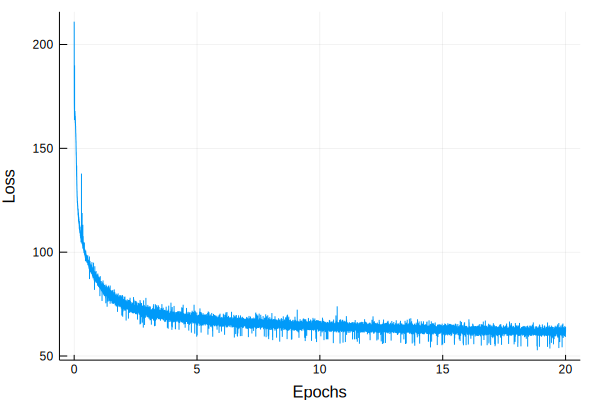

In [14]:
# Plot the loss over time to show rough convergence
using Plots
l_idxs = collect(1:length(losses))./num_batches
Plots.plot(l_idxs, losses; xlabel="Epochs", ylabel="Loss", legend=nothing)

## Using the trained model

To make use of the trained model, we `fetch()` the result back from the loop task, then convert the trained model back to a CPU-compatible construction (e.g. a `Chain` rather than an `ImmutableChain`), `Array`'s instead of `XRTArrays`, etc...

In [17]:
# Fetch value from `loop_task`
ret = fetch(loop_task)
trained_model = convert(typeof(ret[1]).parameters[1], ret[1]);

# Convert all XRTArray values to just normal arrays, `ImmutableChain`s to `Chain`s, etc...:
trained_model = map_to_cpu(trained_model)

# Initialize trained model to deal with a single character at a time.  The character being
# sent through the model here doesn't matter; just the shape of it.
trained_model = initialize_state(trained_model, Flux.onehot('a', alphabet))

Chain(Recur(LSTMCell(68, 256)), Recur(LSTMCell(256, 256)), Dense(256, 68))

In [18]:
# We use the weighted sampling routines from `StatsBase` to read off the next
# character from the LSTM output, otherwise it just spits out the same sentence
# over and over again, as it is the "most likely" sentence.
using StatsBase

# Take a random value from the alphabet as our initial input
x = rand(alphabet)

# For 1000 timesteps, push `x` through the model, resulting in a `y_hat`,
# then use that with `wsample` to sample a new `x`.  Print that new `x` out,
# and loop around again, and again, and again, printing out our beautiful
# prose each time.
for idx in 1:1000
    y_hat = softmax(trained_model(Flux.onehot(x, alphabet)))
    x = wsample(alphabet, vec(y_hat))
    print(x)
end

;
Not verifed rehearts,
Of words.

ABHORSON:
I do follow him a prologue o' the supury,
And we give turn for nest.

ANTIPHOLUS OF SYRACUSE:
What man he does?--a milliodly grace his face;
Their finger at Saint Apon a grace.
Captives, how! I should not have thee forsworn. I will not: you'll have no better; next of your peril and hence!

Morrel and take order of me!
Dost thou not trow? this agreeing gifts,
Or be a horse be squade.

DOCTOR CAIUS:
Ay, all; and at my fortune his draws on lime quickly bear.

CAPHIS:

Messenger:
Fie on their eyes, and calls your horse-food,
her hand of late!

DUKE VINCENTIO:
Come not how bastard; for your laster semet,
And Ferve of yours are our
wishing, thou drave the sceptre rigorim, here is there woest between this offence.

Second Servant:
First, not speak again.

ESCALUS:
Go Till by the royal yoke:
And here do you keep rich by former thick, blushectly show'd
Bathe much service,
And thus our kings are pape, and be enough.
We see so maidenheard for hell,
For